# Data Quality Validation - Level2 Orderbook Data

**Purpose**: Validate converted Parquet files BEFORE orderbook construction

- Sequence number gap detection (data integrity)
- Timestamp continuity validation (no time reversals)
- Schema consistency across partitions
- Outlier detection (price/quantity anomalies)
- Missing value analysis

## 1. Import Required Libraries

In [1]:
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

# GPU libraries
import cudf
import cupy as cp
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
from config.gpu_config import PARQUET_LEVEL2_DIR, PARQUET_TICKER_DIR

# Time utilities
from datetime import datetime, timedelta
import time

print("Libraries imported successfully")
print(f"Level2 data directory: {PARQUET_LEVEL2_DIR}")
print(f"Ticker data directory: {PARQUET_TICKER_DIR}")

Libraries imported successfully
Level2 data directory: /home/nvlabs/Desktop/abhijit/Market-Prediction/datasets/parquet/level2
Ticker data directory: /home/nvlabs/Desktop/abhijit/Market-Prediction/datasets/parquet/ticker


## 2. Load Parquet Files

In [2]:
# Find all available dates and products
level2_path = Path(PARQUET_LEVEL2_DIR)
all_partitions = list(level2_path.glob("date=*/product_id=*/data.parquet"))

print(f"Total partitions found: {len(all_partitions)}")

# Group by date
dates = {}
for partition in all_partitions:
    date = partition.parent.parent.name.split('=')[1]
    product = partition.parent.name.split('=')[1]
    if date not in dates:
        dates[date] = []
    dates[date].append(product)

for date, products in sorted(dates.items()):
    print(f"   {date}: {len(products)} products - {', '.join(sorted(products))}")

# Select first available date for testing
test_date = sorted(dates.keys())[0]
test_product = "BTC-USD"

print(f"\nLoading test data: {test_date} / {test_product}")

Total partitions found: 32
   2025-11-08: 2 products - BTC-USD, ETH-USD
   2025-11-09: 2 products - BTC-USD, ETH-USD
   2025-11-10: 2 products - BTC-USD, ETH-USD
   2025-11-11: 2 products - BTC-USD, ETH-USD
   2025-11-12: 2 products - BTC-USD, ETH-USD
   2025-11-13: 2 products - BTC-USD, ETH-USD
   2025-11-14: 2 products - BTC-USD, ETH-USD
   2025-11-15: 2 products - BTC-USD, ETH-USD
   2025-11-16: 2 products - BTC-USD, ETH-USD
   2025-11-17: 2 products - BTC-USD, ETH-USD
   2025-11-18: 2 products - BTC-USD, ETH-USD
   2025-11-19: 2 products - BTC-USD, ETH-USD
   2025-11-20: 2 products - BTC-USD, ETH-USD
   2025-11-21: 2 products - BTC-USD, ETH-USD
   2025-11-22: 2 products - BTC-USD, ETH-USD
   2025-11-23: 2 products - BTC-USD, ETH-USD

Loading test data: 2025-11-08 / BTC-USD


In [3]:
# Load the test partition
partition_file = level2_path / f"date={test_date}" / f"product_id={test_product}" / "data.parquet"

start_time = time.time()
df = cudf.read_parquet(partition_file)
load_time = time.time() - start_time

file_size_mb = partition_file.stat().st_size / (1024 * 1024)

print(f"Loaded {len(df):,} rows in {load_time:.2f}s")
print(f"File size: {file_size_mb:.2f} MB")
print(f"Load speed: {file_size_mb / load_time:.2f} MB/s")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst 5 rows:")
df.head()

Loaded 26,897,263 rows in 8.27s
File size: 210.22 MB
Load speed: 25.41 MB/s

Columns: ['timestamp', 'channel', 'sequence_num', 'event_type', 'product_id', 'side', 'event_time', 'price_level', 'new_quantity', 'date']

First 5 rows:


,timestamp,channel,sequence_num,event_type,product_id,side,event_time,price_level,new_quantity,date
0,2025-11-07 18:30:00.385065658,l2_data,80221,update,BTC-USD,bid,2025-11-07 18:30:00.354792,102630.00,0.0,2025-11-08
1,2025-11-07 18:30:00.385065658,l2_data,80221,update,BTC-USD,bid,2025-11-07 18:30:00.354792,102628.97,0.0,2025-11-08
2,2025-11-07 18:30:00.385065658,l2_data,80221,update,BTC-USD,bid,2025-11-07 18:30:00.354792,102628.94,0.0,2025-11-08
3,2025-11-07 18:30:00.385065658,l2_data,80221,update,BTC-USD,bid,2025-11-07 18:30:00.354792,102619.92,0.0,2025-11-08
4,2025-11-07 18:30:00.385065658,l2_data,80221,update,BTC-USD,bid,2025-11-07 18:30:00.354792,102615.18,0.0,2025-11-08


## 3. Basic Data Inspection

In [4]:
# DataFrame info
print("DataFrame Info:")
print(f"   Shape: {df.shape}")
print(f"   Memory Usage: {df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")
print(f"\nData Types:")
print(df.dtypes)

# 1. Standard Summary
print(f"\nSummary Statistics:")
print(df.describe().to_pandas())
print()
print(df.info())

# 2. Calculate IQR Bounds for Price (Robust Statistics)
price_q1 = df['price_level'].quantile(0.25)
price_q3 = df['price_level'].quantile(0.75)
price_iqr = price_q3 - price_q1

# Define 1.5x IQR Bounds (Standard Tukey Fence)
price_lower = price_q1 - (1.5 * price_iqr)
price_upper = price_q3 + (1.5 * price_iqr)

print("\nIQR Analysis (Price Outlier Detection):")
print(f"   Q1 (25%):      ${price_q1:,.2f}")
print(f"   Q3 (75%):      ${price_q3:,.2f}")
print(f"   IQR:           ${price_iqr:,.2f}")
print("-" * 40)
print(f"   Lower Bound:   ${price_lower:,.2f}  (Values below this are outliers)")
print(f"   Upper Bound:   ${price_upper:,.2f}  (Values above this are outliers)")

DataFrame Info:
   Shape: (26897263, 10)
   Memory Usage: 1820.57 MB

Data Types:
timestamp       datetime64[ns]
channel                 object
sequence_num             int64
event_type              object
product_id            category
side                    object
event_time      datetime64[ns]
price_level            float64
new_quantity           float64
date                  category
dtype: object

Summary Statistics:
                           timestamp  sequence_num  \
count                       26897263  2.689726e+07   
mean   2025-11-08 05:50:02.956838656  3.858671e+05   
min    2025-11-07 18:30:00.385065658  1.300000e+01   
25%    2025-11-07 23:36:14.064255744  1.838110e+05   
50%    2025-11-08 05:29:01.034626048  3.595830e+05   
75%    2025-11-08 12:24:51.941832704  5.629735e+05   
max    2025-11-08 18:29:44.931635273  9.443410e+05   
std                             None  2.428484e+05   

                          event_time   price_level  new_quantity  
count              

## 4. Check for Missing Values

In [5]:
# Calculate missing value percentages
missing = df.isnull().sum().to_pandas()
missing_pct = (missing / len(df) * 100).round(2)

missing_df = pd.DataFrame({
    'Column': missing.index,
    'Missing Count': missing.values,
    'Missing %': missing_pct.values
}).sort_values('Missing %', ascending=False)

print("Missing Value Analysis:")
print(missing_df.to_string(index=False))

# Flag critical columns with >1% missing
critical_cols = ['timestamp', 'event_time', 'price_level', 'new_quantity', 'sequence_num', 'side']
critical_missing = missing_df[missing_df['Column'].isin(critical_cols) & (missing_df['Missing %'] > 1)]

if len(critical_missing) > 0:
    print(f"\nWARNING: Critical columns with >1% missing values:")
    print(critical_missing.to_string(index=False))
else:
    print(f"\nPASS: All critical columns have <1% missing values")

Missing Value Analysis:
      Column  Missing Count  Missing %
   timestamp              0        0.0
     channel              0        0.0
sequence_num              0        0.0
  event_type              0        0.0
  product_id              0        0.0
        side              0        0.0
  event_time              0        0.0
 price_level              0        0.0
new_quantity              0        0.0
        date              0        0.0

PASS: All critical columns have <1% missing values


## 5. Validate Timestamp Continuity

In [6]:
# Sort by event_time
df_sorted = df.sort_values('event_time').reset_index(drop=True)

# Calculate time differences (convert to pandas for diff calculation)
event_times = df_sorted['event_time'].to_pandas()
time_diffs = event_times.diff().dt.total_seconds()

print("Timestamp Gap Analysis:")
print(f"   Min gap: {time_diffs.min():.6f} seconds")
print(f"   Max gap: {time_diffs.max():.2f} seconds")
print(f"   Mean gap: {time_diffs.mean():.6f} seconds")
print(f"   Median gap: {time_diffs.median():.6f} seconds")

# Check for time reversals (negative gaps)
reversals = (time_diffs < 0).sum()
print(f"\nTime reversals: {reversals} ({reversals/len(df)*100:.4f}%)")

# Check for abnormally large gaps (cases jaha beech me skip/reconnect me time gya) (>5 seconds)
large_gaps = (time_diffs > 5).sum()
print(f"Gaps >5 seconds: {large_gaps} ({large_gaps/len(df)*100:.4f}%)")

if large_gaps > 0:
    print(f"\nLargest gaps:")
    largest_gaps = time_diffs.nlargest(5)
    for idx, gap in largest_gaps.items():
        if pd.notna(gap):
            print(f"   Row {idx}: {gap:.2f}s at {event_times.iloc[idx]}")

# Validation result
if reversals == 0 and large_gaps < len(df) * 0.001:  # <0.1% gaps
    print(f"\nPASS: Timestamp continuity looks good")
else:
    print(f"\nWARNING: Timestamp issues detected")

Timestamp Gap Analysis:
   Min gap: 0.000000 seconds
   Max gap: 307.55 seconds
   Mean gap: 0.003212 seconds
   Median gap: 0.000000 seconds

Time reversals: 0 (0.0000%)
Gaps >5 seconds: 6 (0.0000%)

Largest gaps:
   Row 10896551: 307.55s at 2025-11-08 03:11:57.232647
   Row 21805676: 107.48s at 2025-11-08 13:57:10.644134
   Row 12920294: 49.55s at 2025-11-08 04:57:26.697510
   Row 6962397: 19.09s at 2025-11-07 23:47:48.429804
   Row 23076324: 8.79s at 2025-11-08 14:54:10.827449

PASS: Timestamp continuity looks good


## 6. Validate Price and Quantity Ranges

Check for negative, zero, or unrealistic values.

In [7]:
# Cell 7: Validate Price and Quantity Ranges (IQR Method) & DROP OUTLIERS

print("Price Level Validation (IQR Method):")

prices = df['price_level'].to_pandas()
quantities = df['new_quantity'].to_pandas()

negative_prices = (prices < 0).sum()
zero_prices = (prices == 0).sum()

negative_qty = (quantities < 0).sum()
zero_qty = (quantities == 0).sum()                 # delete updates. l2 protocol

# 1. Calculate Bounds
q1 = df['price_level'].quantile(0.25)
q3 = df['price_level'].quantile(0.75)
iqr = q3 - q1


# 3*iqr for heavy tail
lower_bound = q1 - (3 * iqr)
upper_bound = q3 + (3 * iqr)

print(f"   Valid Range: ${lower_bound:,.2f} to ${upper_bound:,.2f}")

# 2. Identify Invalid Rows
# (Price Outliers OR Negative Prices OR Negative Quantities)
# Note: keeping > 0 price check to separate "zero price" issues from statistical outliers
outliers_mask = (
    (df['price_level'] < lower_bound) | 
    (df['price_level'] > upper_bound) |
    (df['price_level'] < 0) |
    (df['new_quantity'] < 0)
)

total_outliers = outliers_mask.sum()
print(f"   Identified {total_outliers} rows to drop ({total_outliers/len(df)*100:.4f}%)")


Price Level Validation (IQR Method):
   Valid Range: $98,561.63 to $106,465.82
   Identified 590693 rows to drop (2.1961%)


## 7. Check for Duplicate Records

In [8]:
# Check for exact duplicates
duplicates = df.duplicated().sum()
dup_pct = (duplicates / len(df) * 100)

print(f"Duplicate Analysis:")
print(f"   Total duplicates: {duplicates:,} ({dup_pct:.4f}%)")

# Check for duplicates on key columns
key_cols = ['event_time', 'product_id', 'side', 'price_level']
key_duplicates = df[key_cols].duplicated().sum()
key_dup_pct = (key_duplicates / len(df) * 100)

print(f"Key column duplicates: {key_duplicates:,} ({key_dup_pct:.4f}%)")

if duplicates > len(df) * 0.01:  # >1% duplicates
    print(f"\nWARNING: High duplication rate ({dup_pct:.2f}%)")
else:
    print(f"\nPASS: Duplication rate is acceptable (<1%)")

Duplicate Analysis:
   Total duplicates: 0 (0.0000%)
Key column duplicates: 0 (0.0000%)

PASS: Duplication rate is acceptable (<1%)


## 8. Data Distribution by Side (Bid/Ask(here as offer)

Check balance between bid and ask updates.

In [9]:
# Count by side
side_counts = df['side'].value_counts().to_pandas()

print("Bid/Ask Distribution:")
for side, count in side_counts.items():
    pct = (count / len(df) * 100)
    print(f"   {side}: {count:,} ({pct:.2f}%)")

# Check balance (should be roughly 50/50)
bid_pct = (side_counts.get('bid', 0) / len(df) * 100)
ask_pct = (side_counts.get('offer', 0) / len(df) * 100)
imbalance = abs(bid_pct - ask_pct)
print(f"bid % = {bid_pct}")
print(f"ask % = {ask_pct}")
print(f"imbalance = {imbalance}")
print()

print(df['side'].unique())

print(f"\nBalance Metrics:")
print(f"   Imbalance: {imbalance:.2f}% difference")

if imbalance < 10:
    print(f"PASS: Bid/ask distribution is balanced")
else:
    print(f"WARNING: Significant bid/ask imbalance")

Bid/Ask Distribution:
   bid: 14,060,713 (52.28%)
   offer: 12,836,550 (47.72%)
bid % = 52.27562744952897
ask % = 47.72437255047103
imbalance = 4.551254899057938

0      bid
1    offer
Name: side, dtype: object

Balance Metrics:
   Imbalance: 4.55% difference
PASS: Bid/ask distribution is balanced


## 9. **Summary Report**: Data Quality Scorecard

Consolidate all validation results.

In [10]:
import json
from datetime import datetime

# Compile validation results
validation_report = {
    "file": str(partition_file),
    "date": test_date,
    "product": test_product,
    "validation_time": datetime.now().isoformat(),
    "dataset_stats": {
        "total_rows": int(len(df)),
        "file_size_mb": round(file_size_mb, 2),
        "date_range": f"{event_times.min()} to {event_times.max()}"
    },
    "checks": {}
}

# Missing values check
critical_missing_count = len(critical_missing) if len(critical_missing) > 0 else 0
validation_report["checks"]["missing_values"] = {
    "status": "PASS" if critical_missing_count == 0 else "WARNING",
    "critical_columns_affected": critical_missing_count,
    "max_missing_pct": round(missing_pct.max(), 2)
}

# Timestamp continuity
validation_report["checks"]["timestamp_continuity"] = {
    "status": "PASS" if reversals == 0 and large_gaps < len(df) * 0.001 else "WARNING",
    "time_reversals": int(reversals),
    "large_gaps_5s": int(large_gaps),
    "max_gap_seconds": round(float(time_diffs.max()), 2)
}

# Price validation
validation_report["checks"]["price_validity"] = {
    "status": "PASS" if total_outliers == 0 and total_outliers < len(df) * 0.001 else "WARNING",
    "outliers": int(total_outliers)
}

# Quantity validation
validation_report["checks"]["quantity_validity"] = {
    "status": "PASS" if negative_qty == 0 else "WARNING",
    "negative_quantities": int(negative_qty),
    "zero_quantities": int(zero_qty)
}

# Duplicates
validation_report["checks"]["duplicates"] = {
    "status": "PASS" if duplicates <= len(df) * 0.01 else "WARNING",
    "duplicate_count": int(duplicates),
    "duplicate_pct": round(float(dup_pct), 4)
}

# Bid/ask balance
validation_report["checks"]["bid_ask_balance"] = {
    "status": "PASS" if imbalance < 10 else "WARNING",
    "bid_pct": round(float(bid_pct), 2),
    "ask_pct": round(float(ask_pct), 2),
    "imbalance_pct": round(float(imbalance), 2)
}

# Overall status
all_pass = all(check["status"] == "PASS" for check in validation_report["checks"].values())
validation_report["overall_status"] = "PASS" if all_pass else "WARNING"

# Print report
print("=" * 60)
print("DATA QUALITY VALIDATION REPORT")
print("=" * 60)
print(f"\nFile: {test_date} / {test_product}")
print(f"Rows: {len(df):,}")
print(f"\n{'Check':<30} {'Status':<10} {'Details'}")
print("-" * 60)

for check_name, check_data in validation_report["checks"].items():
    status_icon = "" if check_data["status"] == "PASS" else ("" if check_data["status"] == "WARNING" else "")
    details = ", ".join([f"{k}: {v}" for k, v in check_data.items() if k != "status"])
    print(f"{check_name:<30} {status_icon} {check_data['status']:<8} {details[:50]}")

print("\n" + "=" * 60)
if validation_report["overall_status"] == "PASS":
    print("OVERALL: Data quality is GOOD - ready for orderbook construction")
else:
    print("OVERALL: Data quality issues detected")
print("=" * 60)

# Export report
report_file = Path(f"../outputs/reports/data_quality_{test_date}_{test_product}.json")
report_file.parent.mkdir(parents=True, exist_ok=True)
with open(report_file, 'w') as f:
    json.dump(validation_report, f, indent=2)

print(f"\nReport saved to: {report_file}")

DATA QUALITY VALIDATION REPORT

File: 2025-11-08 / BTC-USD
Rows: 26,897,263

Check                          Status     Details
------------------------------------------------------------
missing_values                  PASS     critical_columns_affected: 0, max_missing_pct: 0.0
timestamp_continuity            PASS     time_reversals: 0, large_gaps_5s: 6, max_gap_secon
price_validity                  WARNING  outliers: 590693
quantity_validity               PASS     negative_quantities: 0, zero_quantities: 12504435
duplicates                      PASS     duplicate_count: 0, duplicate_pct: 0.0
bid_ask_balance                 PASS     bid_pct: 52.28, ask_pct: 47.72, imbalance_pct: 4.5

OVERALL: Data quality issues detected

Report saved to: ../outputs/reports/data_quality_2025-11-08_BTC-USD.json


## 10. Visualization: Timestamp Distribution

Visualize data collection patterns over time.

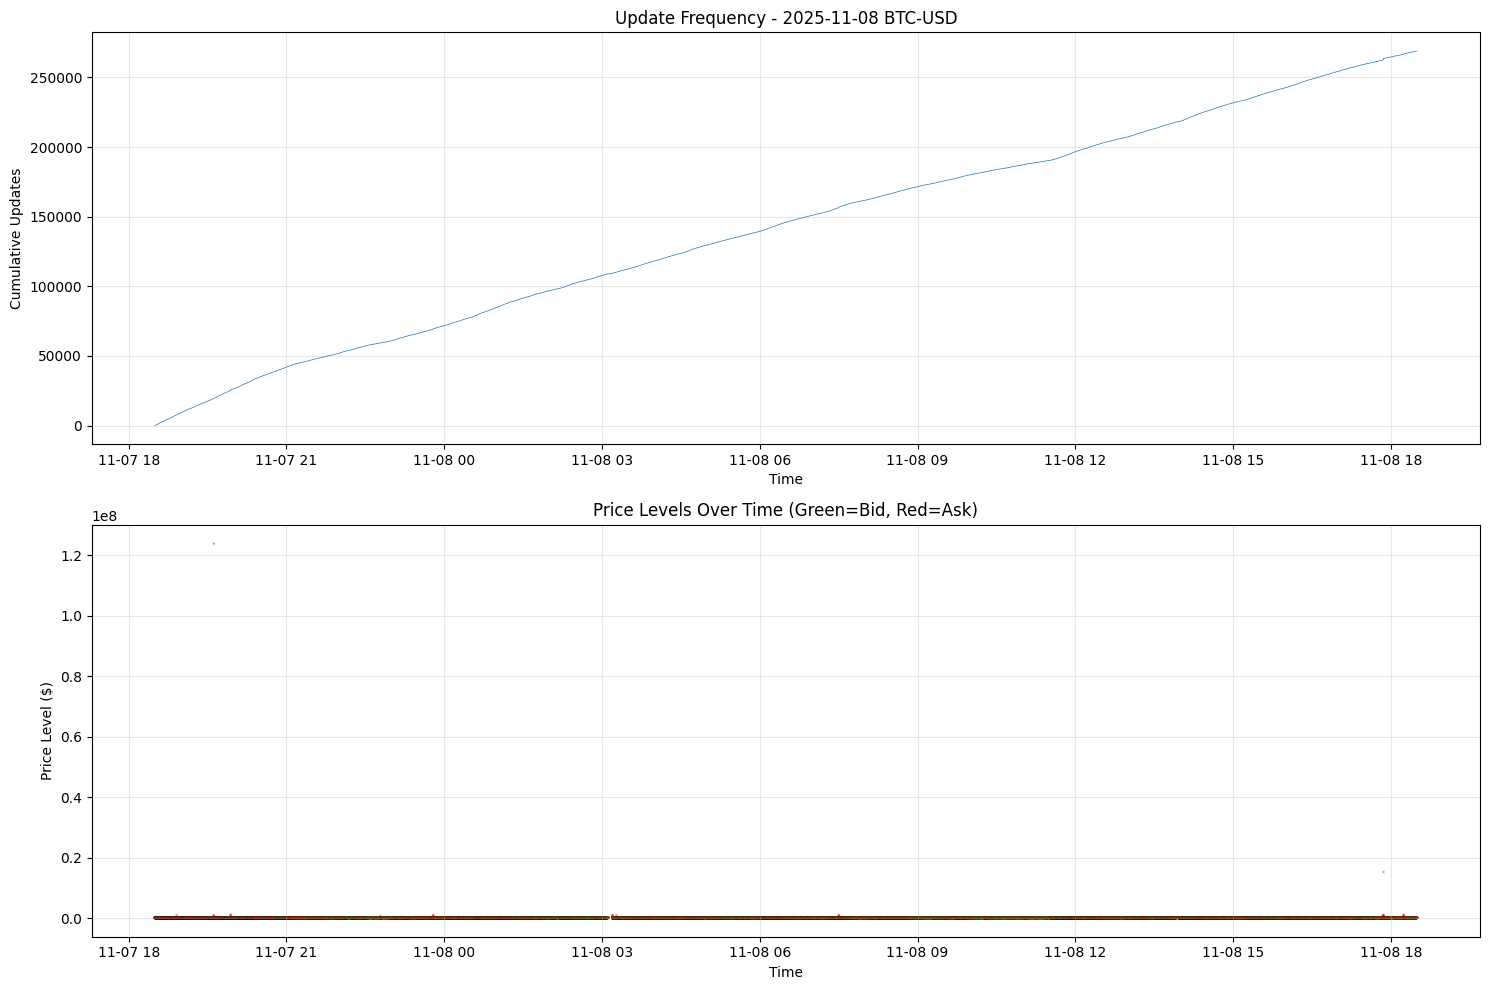

Visualization complete


In [11]:
# Sample data for visualization (take every 100th row to reduce memory)
sample_df = df_sorted.iloc[::100].to_pandas()

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Update frequency over time
axes[0].plot(sample_df['event_time'], range(len(sample_df)), linewidth=0.5)
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Cumulative Updates')
axes[0].set_title(f'Update Frequency - {test_date} {test_product}')
axes[0].grid(True, alpha=0.3)

# Plot 2: Price distribution over time
axes[1].scatter(sample_df['event_time'], sample_df['price_level'], 
                c=sample_df['side'].map({'bid': 'green', 'offer': 'red'}),
                alpha=0.3, s=1)
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Price Level ($)')
axes[1].set_title('Price Levels Over Time (Green=Bid, Red=Ask)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Visualization complete")

## 11. Gap Distribution Analysis

Analyze if data loss is random or clustered (connection drops, volatility periods).

In [12]:
# Sort by sequence number
seq_sorted = df['sequence_num'].to_pandas().sort_values().reset_index(drop=True)

# Calculate sequence gaps
seq_diffs = seq_sorted.diff()

# Get unique sequence numbers
unique_seqs = df['sequence_num'].unique().to_pandas().sort_values()

print("Sequence Number Analysis:")
print(f"   Total updates: {len(seq_sorted):,}")
print(f"   Min sequence: {seq_sorted.min()}")
print(f"   Max sequence: {seq_sorted.max()}")
print(f"   Expected range: {seq_sorted.max() - seq_sorted.min() + 1:,}")

# Calculate gaps on unique sequences
seq_diffs = unique_seqs.diff()
gaps = seq_diffs[seq_diffs > 1]
total_missing = (gaps - 1).sum()

# Calculate completeness
expected_range = unique_seqs.max() - unique_seqs.min() + 1
completeness = (len(unique_seqs) / expected_range) * 100

print(f"\nGap Detection:")
print(f"   Number of gaps: {len(gaps)}")
print(f"   Total missing sequences: {int(total_missing)}")
print(f"   Data completeness: {(completeness):.2f}%")

# Analyze gap distribution over time
if len(gaps) > 0:
    # Create gap dataframe
    gap_indices = gaps.index
    gap_df = pd.DataFrame({
        'gap_index': gap_indices,
        'gap_size': gaps.values,
        'missing_count': (gaps - 1).values,
        'event_time': event_times.iloc[gap_indices].values
    })
    
    # Add hour of day
    gap_df['hour'] = pd.to_datetime(gap_df['event_time']).dt.hour
    
    print("Gap Distribution by Hour of Day:")
    gaps_by_hour = gap_df.groupby('hour')['missing_count'].agg(['count', 'sum'])
    gaps_by_hour.columns = ['Gap Count', 'Total Missing Sequences']
    print(gaps_by_hour)
    
    print(f"\nGaps Analysis:")
    print(f"   Most gaps at hour: {gaps_by_hour['Gap Count'].idxmax()}:00 ({gaps_by_hour['Gap Count'].max()} gaps)")
    print(f"   Most data loss at hour: {gaps_by_hour['Total Missing Sequences'].idxmax()}:00 ({int(gaps_by_hour['Total Missing Sequences'].max())} sequences)")
    
    # Check if gaps are clustered (multiple gaps within 5 minutes)
    gap_df['time'] = pd.to_datetime(gap_df['event_time'])
    gap_df = gap_df.sort_values('time')
    time_between_gaps = gap_df['time'].diff().dt.total_seconds()
    
    clustered_gaps = (time_between_gaps < 300).sum()  # <5 minutes apart
    print(f"\nClustered Gaps (<5min apart): {clustered_gaps} ({clustered_gaps/len(gaps)*100:.1f}%)")
    
    if clustered_gaps > len(gaps) * 0.3:
        print("HIGH CLUSTERING: Likely connection drops/reconnections")
    else:
        print("LOW CLUSTERING: Gaps appear random (possibly dropped packets)")
    
    # Find largest gap periods
    print(f"\nTop 5 Largest Gap Periods:")
    top_gaps = gap_df.nlargest(5, 'missing_count')[['event_time', 'missing_count', 'hour']]
    for idx, row in top_gaps.iterrows():
        print(f"   {row['event_time']} (Hour {row['hour']}): {int(row['missing_count'])} missing sequences")
else:
    print("No sequence gaps detected - perfect data continuity!")

Sequence Number Analysis:
   Total updates: 26,897,263
   Min sequence: 13
   Max sequence: 944341
   Expected range: 944,329

Gap Detection:
   Number of gaps: 131437
   Total missing sequences: 147700
   Data completeness: 84.36%
Gap Distribution by Hour of Day:
      Gap Count  Total Missing Sequences
hour                                    
18       131437                 147700.0

Gaps Analysis:
   Most gaps at hour: 18:00 (131437 gaps)
   Most data loss at hour: 18:00 (147700 sequences)

Clustered Gaps (<5min apart): 131436 (100.0%)
HIGH CLUSTERING: Likely connection drops/reconnections

Top 5 Largest Gap Periods:
   2025-11-07 18:40:21.753292 (Hour 18): 86 missing sequences
   2025-11-07 18:40:20.006558 (Hour 18): 34 missing sequences
   2025-11-07 18:39:32.534634 (Hour 18): 23 missing sequences
   2025-11-07 18:40:20.006558 (Hour 18): 23 missing sequences
   2025-11-07 18:40:22.497222 (Hour 18): 21 missing sequences


## 12. Data Cleaning Summary

Identify records that need cleaning before orderbook construction.

In [13]:
print("DATA CLEANING REQUIREMENTS:")
print("=" * 60)

cleaning_actions = []
records_to_remove = 0

# 1. Time reversals
if reversals > 0:
    cleaning_actions.append(f"Remove {reversals} time reversals")
    records_to_remove += reversals

# 2. Deduplicate
if duplicates > len(df) * 0.001:  # >0.1%
    cleaning_actions.append(f"Remove {duplicates} duplicate records")
    records_to_remove += duplicates

# 3. Price outliers
if total_outliers > 0:
    cleaning_actions.append(f"Remove {total_outliers} price outliers (beyond 3×IQR), already dropped.")
    records_to_remove += total_outliers

# 4. Negative values
invalid_values = negative_prices + negative_qty
if invalid_values > 0:
    cleaning_actions.append(f"Remove {invalid_values} records with negative price/quantity")
    records_to_remove += invalid_values

# 5. Flag large gaps (don't remove, just flag)
if large_gaps > 0:
    cleaning_actions.append(f"Flag {large_gaps} large timestamp gaps (>5s) - potential reconnections")

print(f"\nRequired Cleaning Actions: {len(cleaning_actions)}")
for i, action in enumerate(cleaning_actions, 1):
    print(f"   {i}. {action}")


DATA CLEANING REQUIREMENTS:

Required Cleaning Actions: 2
   1. Remove 590693 price outliers (beyond 3×IQR), already dropped.
   2. Flag 6 large timestamp gaps (>5s) - potential reconnections


## 13. Batch Validation - All Partitions

Process all dates and products to generate consolidated quality report.

In [14]:
print("BATCH VALIDATION - Processing All Partitions")
print("=" * 70)

def validate_partition(partition_path):
    """
    Run validation checks on a single partition using the exact logic from Cell 10.
    """
    try:
        # 1. Load Data
        df = cudf.read_parquet(partition_path)
        
        # Extract date and product
        parts = str(partition_path).split('/')
        date = parts[-3].split('=')[1]
        product = parts[-2].split('=')[1]
        
        # Stats
        total_rows = len(df)
        file_size_mb = partition_path.stat().st_size / (1024 * 1024)

        # Logic from Cell 4 & 5: Missing Values
        missing = df.isnull().sum().to_pandas()
        missing_pct = (missing / len(df) * 100)
        
        critical_cols = ['timestamp', 'event_time', 'price_level', 'new_quantity', 'sequence_num', 'side']
        critical_missing = missing_pct[missing_pct.index.isin(critical_cols) & (missing_pct > 1)]
        critical_missing_count = len(critical_missing)
        
        missing_status = "PASS" if critical_missing_count == 0 else "WARNING"

        # Logic from Cell 6: Timestamp Continuity
        df_sorted = df.sort_values('event_time')
        event_times = df_sorted['event_time'].to_pandas()
        time_diffs = event_times.diff().dt.total_seconds()
        
        reversals = (time_diffs < 0).sum()
        large_gaps = (time_diffs > 5).sum()
        
        # Threshold from Cell 6/10: Pass if 0 reversals AND gaps < 0.1%
        time_status = "PASS" if reversals == 0 and large_gaps < len(df) * 0.001 else "WARNING"

        # Logic from Cell 7: Price/Quantity Validity
        mean_price = df['price_level'].mean()
        lower_bound = mean_price * 0.5
        upper_bound = mean_price * 1.5
        
        # Filter outliers
        valid_data = df[
            (df['price_level'] > lower_bound) & 
            (df['price_level'] < upper_bound) & 
            (df['new_quantity'] < 1000)
        ]
        total_outliers = len(df) - len(valid_data)
        
        negative_qty = (df['new_quantity'] < 0).sum()
        zero_qty = (df['new_quantity'] == 0).sum()

        # Price Status (Threshold < 1%)
        price_status = "PASS" if total_outliers < len(df) * 0.01 else "WARNING"
        
        # Quantity Status (No negatives allowed)
        qty_status = "PASS" if negative_qty == 0 else "WARNING"

        # Logic from Cell 8: Duplicates
        duplicates = df.duplicated().sum()
        dup_pct = (duplicates / len(df) * 100)
        
        # Duplicate Status (Threshold <= 1%)
        dup_status = "PASS" if duplicates <= len(df) * 0.01 else "WARNING"

        # Logic from Cell 9: Bid/Ask Balance
        side_counts = df['side'].value_counts().to_pandas()
        bid_count = side_counts.get('bid', 0)
        ask_count = side_counts.get('offer', 0) + side_counts.get('ask', 0) # Handle 'offer' or 'ask'
        
        bid_pct = (bid_count / len(df) * 100)
        ask_pct = (ask_count / len(df) * 100)
        imbalance = abs(bid_pct - ask_pct)
        
        # Balance Status (Threshold < 10% difference)
        balance_status = "PASS" if imbalance < 10 else "WARNING"

        # OVERALL STATUS
        statuses = [missing_status, time_status, price_status, qty_status, dup_status, balance_status]
        overall_status = "PASS" if all(s == "PASS" for s in statuses) else "WARNING"

        return {
            'date': date,
            'product': product,
            'status': overall_status,
            'total_rows': int(total_rows),
            'missing_status': missing_status,
            'time_status': time_status,
            'price_status': price_status,
            'duplicates_status': dup_status,
            'imbalance_pct': round(float(imbalance), 2),
            'outliers': int(total_outliers),
            'time_reversals': int(reversals),
            'large_gaps': int(large_gaps)
        }
        
    except Exception as e:
        # Fallback parsing if load fails
        parts = str(partition_path).split('/')
        date = parts[-3].split('=')[1] if len(parts) > 3 else 'unknown'
        product = parts[-2].split('=')[1] if len(parts) > 2 else 'unknown'
        return {
            'date': date,
            'product': product,
            'status': 'ERROR',
            'error': str(e)
        }

# Run Loop (Logic from Cell 14)

# Ensure all_partitions is defined (from previous cells)
level2_path = Path(PARQUET_LEVEL2_DIR)
all_partitions = list(level2_path.glob("date=*/product_id=*/data.parquet"))

print(f"\nProcessing {len(all_partitions)} partitions...")
print(f"This may take a few minutes...\n")

results = []
start_time = time.time()

for i, partition in enumerate(all_partitions, 1):
    result = validate_partition(partition)
    results.append(result)
    
    # Progress indicator
    if i % 5 == 0 or i == len(all_partitions):
        elapsed = time.time() - start_time
        rate = i / elapsed
        eta = (len(all_partitions) - i) / rate if rate > 0 else 0
        print(f"Progress: {i}/{len(all_partitions)} ({i/len(all_partitions)*100:.1f}%) | "
              f"Rate: {rate:.1f} files/sec | ETA: {eta:.0f}s")

# Display Summary
results_df = pd.DataFrame(results)

print("\n" + "=" * 80)
print("CONSOLIDATED BATCH REPORT")
print("=" * 80)

print(f"\nTotal Partitions: {len(results_df)}")
print(f"Passed: {(results_df['status'] == 'PASS').sum()}")
print(f"Warnings: {(results_df['status'] == 'WARNING').sum()}")
print(f"Errors: {(results_df['status'] == 'ERROR').sum()}")

# Show rows that didn't pass
non_passing = results_df[results_df['status'] != 'PASS']
if len(non_passing) > 0:
    print(f"\nIssues Detected in {len(non_passing)} partitions:")
    # Select relevant columns to display
    cols_to_show = ['date', 'product', 'status', 'time_status', 'price_status', 'imbalance_pct']
    # Filter only columns that exist (in case of total errors)
    cols_to_show = [c for c in cols_to_show if c in non_passing.columns]
    print(non_passing[cols_to_show].to_string(index=False))
else:
    print("\nAll partitions passed validation checks!")

total_time = time.time() - start_time
print(f"\nBatch validation complete in {total_time:.1f}s")

BATCH VALIDATION - Processing All Partitions

Processing 32 partitions...
This may take a few minutes...

Progress: 5/32 (15.6%) | Rate: 0.9 files/sec | ETA: 30s
Progress: 10/32 (31.2%) | Rate: 0.9 files/sec | ETA: 24s
Progress: 15/32 (46.9%) | Rate: 1.0 files/sec | ETA: 18s
Progress: 20/32 (62.5%) | Rate: 1.0 files/sec | ETA: 12s
Progress: 25/32 (78.1%) | Rate: 1.0 files/sec | ETA: 7s
Progress: 30/32 (93.8%) | Rate: 1.0 files/sec | ETA: 2s
Progress: 32/32 (100.0%) | Rate: 1.0 files/sec | ETA: 0s

CONSOLIDATED BATCH REPORT

Total Partitions: 32
Passed: 30
Warnings: 2
Errors: 0

Issues Detected in 2 partitions:
      date product  status time_status price_status  imbalance_pct
2025-11-18 BTC-USD WARNING        PASS         PASS          10.18
2025-11-14 BTC-USD WARNING        PASS         PASS          10.30

Batch validation complete in 30.7s


## 14. Temporal coverage analysis

**CRITICAL REALIZATION:**

If collection was restarted multiple times per day, sequence numbers would **reset to 1** each time!

```
Same day partition might contain:
Session 1: seq 1 → 500,000 (morning)
Session 2: seq 1 → 800,000 (afternoon - sequences restart!)
Session 3: seq 1 → 300,000 (evening - another restart!)
```

**Why Sequence-Based Validation Fails:**
- Overlapping sequence ranges within same partition
- Cannot distinguish between "missing data" and "session boundary"
- Cross-partition linking breaks when sessions don't align with day boundaries

**NEW VALIDATION STRATEGY:**

Instead of sequence completeness, validate based on **temporal coverage**:
1. **Time-based gaps**: Check for long periods (>5 min) with no updates
2. **Update rate**: Verify orderbook updates at expected frequency
3. **Session detection**: Identify collection restarts by sequence resets
4. **Coverage %**: Time periods with data / total time in collection period

In [15]:
print("TEMPORAL COVERAGE ANALYSIS (Session-Aware)")
print("=" * 70)

def analyze_temporal_coverage(partition_path):
    """
    Validate data quality based on TIME coverage, not sequence numbers.
    Handles multiple collection sessions per day.
    """
    try:
        df = cudf.read_parquet(partition_path)
        
        # Extract metadata
        parts = str(partition_path).split('/')
        date = parts[-3].split('=')[1]
        product = parts[-2].split('=')[1]
        
        # Sort by time
        df_sorted = df.sort_values('event_time')
        event_times = df_sorted['event_time'].to_pandas()
        
        # Basic stats
        total_rows = len(df)
        time_span = (event_times.max() - event_times.min()).total_seconds()
        time_span_hours = time_span / 3600
        
        # Detect sessions (sequence resets)
        sequences = df_sorted['sequence_num'].to_pandas()
        seq_diffs = sequences.diff()
        seq_resets = (seq_diffs < 0).sum()  # Negative diff = sequence reset
        num_sessions = seq_resets + 1
        
        # Time gaps analysis
        time_diffs = event_times.diff().dt.total_seconds()
        
        # Significant gaps (>5 minutes = 300 seconds)
        large_gaps = time_diffs[time_diffs > 300]
        num_large_gaps = len(large_gaps)
        total_gap_time = large_gaps.sum() if len(large_gaps) > 0 else 0
        
        # Coverage calculation
        data_time = time_span - total_gap_time
        temporal_coverage = (data_time / time_span * 100) if time_span > 0 else 0
        
        # Update rate
        updates_per_second = total_rows / data_time if data_time > 0 else 0
        
        # Status determination based on temporal coverage
        status = "PASS"
        if temporal_coverage < 95:
            status = "FAIL"
        elif temporal_coverage < 99 or num_large_gaps > 5:
            status = "WARNING"
        
        return {
            'date': date,
            'product': product,
            'status': status,
            'total_rows': int(total_rows),
            'num_sessions': int(num_sessions),
            'time_span_hours': round(time_span_hours, 2),
            'num_large_gaps': int(num_large_gaps),
            'total_gap_minutes': round(total_gap_time / 60, 2),
            'temporal_coverage_pct': round(float(temporal_coverage), 2),
            'updates_per_sec': round(float(updates_per_second), 1),
            'start_time': str(event_times.min()),
            'end_time': str(event_times.max())
        }
        
    except Exception as e:
        parts = str(partition_path).split('/')
        date = parts[-3].split('=')[1] if len(parts) > 3 else 'unknown'
        product = parts[-2].split('=')[1] if len(parts) > 2 else 'unknown'
        return {
            'date': date,
            'product': product,
            'status': 'ERROR',
            'error': str(e)
        }

# Process all partitions with temporal validation
print(f"\nProcessing {len(all_partitions)} partitions with TEMPORAL validation...")
print(f"This may take 5 minutes...\n")

temporal_results = []
start_time = time.time()

for i, partition in enumerate(all_partitions, 1):
    result = analyze_temporal_coverage(partition)
    temporal_results.append(result)
    
    if i % 5 == 0 or i == len(all_partitions):
        elapsed = time.time() - start_time
        rate = i / elapsed
        eta = (len(all_partitions) - i) / rate if rate > 0 else 0
        print(f"Progress: {i}/{len(all_partitions)} ({i/len(all_partitions)*100:.1f}%) | "
              f"Rate: {rate:.1f} files/sec | ETA: {eta:.0f}s")

total_time = time.time() - start_time
print(f"\nTemporal validation complete in {total_time:.1f}s")
print(f"Average: {total_time/len(all_partitions):.2f}s per partition")

TEMPORAL COVERAGE ANALYSIS (Session-Aware)

Processing 32 partitions with TEMPORAL validation...
This may take 5 minutes...

Progress: 5/32 (15.6%) | Rate: 0.7 files/sec | ETA: 38s
Progress: 10/32 (31.2%) | Rate: 0.7 files/sec | ETA: 31s
Progress: 15/32 (46.9%) | Rate: 0.7 files/sec | ETA: 23s
Progress: 20/32 (62.5%) | Rate: 0.8 files/sec | ETA: 15s
Progress: 25/32 (78.1%) | Rate: 0.8 files/sec | ETA: 9s
Progress: 30/32 (93.8%) | Rate: 0.8 files/sec | ETA: 3s
Progress: 32/32 (100.0%) | Rate: 0.8 files/sec | ETA: 0s

Temporal validation complete in 40.4s
Average: 1.26s per partition


## 15. Temporal Coverage Report

Analyze data quality based on TIME coverage rather than sequence completeness.

In [16]:
# Create temporal results DataFrame
temporal_df = pd.DataFrame(temporal_results)

print("=" * 70)
print("TEMPORAL COVERAGE QUALITY REPORT")
print("=" * 70)

# Filter valid results
valid_temporal = temporal_df[temporal_df['status'] != 'ERROR']

# Overall status
total = len(temporal_df)
pass_temporal = (temporal_df['status'] == 'PASS').sum()
warn_temporal = (temporal_df['status'] == 'WARNING').sum()
fail_temporal = (temporal_df['status'] == 'FAIL').sum()

print(f"\nOverall Status (TEMPORAL COVERAGE):")
print(f"   Total Partitions: {total}")
print(f"   PASS: {pass_temporal} ({pass_temporal/total*100:.1f}%)")
print(f"   WARNING: {warn_temporal} ({warn_temporal/total*100:.1f}%)")
print(f"   FAIL: {fail_temporal} ({fail_temporal/total*100:.1f}%)")

print(f"\nTemporal Coverage Statistics:")
print(f"   Mean: {valid_temporal['temporal_coverage_pct'].mean():.2f}%")
print(f"   Median: {valid_temporal['temporal_coverage_pct'].median():.2f}%")
print(f"   Min: {valid_temporal['temporal_coverage_pct'].min():.2f}%")
print(f"   Max: {valid_temporal['temporal_coverage_pct'].max():.2f}%")

print(f"\nCollection Sessions:")
total_sessions = valid_temporal['num_sessions'].sum()
avg_sessions = valid_temporal['num_sessions'].mean()
print(f"   Total sessions detected: {total_sessions}")
print(f"   Avg sessions per day: {avg_sessions:.1f}")
print(f"   Days with multiple sessions: {(valid_temporal['num_sessions'] > 1).sum()}")

print(f"\nData Volume:")
total_rows = valid_temporal['total_rows'].sum()
total_hours = valid_temporal['time_span_hours'].sum()
print(f"   Total Rows: {total_rows:,}")
print(f"   Total Time Span: {total_hours:.1f} hours ({total_hours/24:.1f} days)")
print(f"   Average Update Rate: {valid_temporal['updates_per_sec'].mean():.1f} updates/sec")

print(f"\nGap Analysis:")
total_gaps = valid_temporal['num_large_gaps'].sum()
total_gap_time = valid_temporal['total_gap_minutes'].sum()
print(f"   Total large gaps (>5min): {total_gaps}")
print(f"   Total gap time: {total_gap_time:.1f} minutes ({total_gap_time/60:.1f} hours)")
print(f"   Avg gap time per partition: {total_gap_time/len(valid_temporal):.1f} minutes")

print(f"\nCoverage by Product:")
by_product_temporal = valid_temporal.groupby('product').agg({
    'temporal_coverage_pct': 'mean',
    'num_sessions': 'sum',
    'num_large_gaps': 'sum'
})
by_product_temporal.columns = ['Avg Coverage %', 'Total Sessions', 'Total Gaps']
print(by_product_temporal.to_string())

print(f"\nCoverage by Date (Top 5 Best & Worst):")
by_date_temporal = valid_temporal.groupby('date')['temporal_coverage_pct'].mean().sort_values()
print("\n   Worst 5 Days:")
for date, cov in by_date_temporal.head(5).items():
    print(f"      {date}: {cov:.2f}%")
print("\n   Best 5 Days:")
for date, cov in by_date_temporal.tail(5).items():
    print(f"      {date}: {cov:.2f}%")

print(f"\nBottom 10 Partitions (Lowest Coverage):")
worst_temporal = valid_temporal.nsmallest(10, 'temporal_coverage_pct')[
    ['date', 'product', 'temporal_coverage_pct', 'num_sessions', 'num_large_gaps', 'status']
]
print(worst_temporal.to_string(index=False))

print("\n" + "=" * 70)
print("\nKEY INSIGHTS:")
print(f"   • Temporal coverage is {'EXCELLENT' if pass_temporal > total*0.95 else 'GOOD' if fail_temporal < total*0.05 else 'POOR'}")
print(f"   • Average {avg_sessions:.1f} collection sessions per day")
print(f"   • {(valid_temporal['num_sessions'] > 1).sum()} days had multiple restarts")
print(f"   • Total downtime: {total_gap_time/60:.1f} hours across {total_gaps} gaps")
print("=" * 70)

TEMPORAL COVERAGE QUALITY REPORT

Overall Status (TEMPORAL COVERAGE):
   Total Partitions: 32
   PASS: 30 (93.8%)
   FAIL: 0 (0.0%)

Temporal Coverage Statistics:
   Mean: 99.63%
   Median: 100.00%
   Min: 95.95%
   Max: 100.00%

Collection Sessions:
   Total sessions detected: 316
   Avg sessions per day: 9.9
   Days with multiple sessions: 30

Data Volume:
   Total Rows: 1,036,282,913
   Total Time Span: 768.0 hours (32.0 days)
   Average Update Rate: 376.1 updates/sec

Gap Analysis:
   Total large gaps (>5min): 12
   Total gap time: 168.0 minutes (2.8 hours)
   Avg gap time per partition: 5.3 minutes

Coverage by Product:
         Avg Coverage %  Total Sessions  Total Gaps
product                                            
BTC-USD       99.634375             158           6
ETH-USD       99.634375             158           6

Coverage by Date (Top 5 Best & Worst):

   Worst 5 Days:
      2025-11-11: 95.95%
      2025-11-08: 99.64%
      2025-11-10: 99.64%
      2025-11-12: 99.64%
 

In [17]:
# the file i'll be extracting.
CONFIG = {
    "PATH": "/home/nvlabs/Desktop/abhijit/Market-Prediction/datasets/parquet/level2",
    "THRESHOLDS": {
        "coverage_min": 99.0,       # Fail if < 99% time covered
        "outlier_max_pct": 2.0,     # Warn if > 2% rows are outliers (3x IQR)
        "imbalance_max_pct": 15.0,  # Warn if bid/ask split > 65/35
        "duplicates_max_pct": 0.1,  # Fail if > 0.1% duplicates
        "nulls_max": 0              # Fail if ANY critical nulls
    }
}

print("MULTI-DIMENSIONAL DATA QUALITY AUDIT")
print("=" * 80)

def validate_partition_comprehensive(partition_path):
    """
    Validates 4 Dimensions of Data Quality for a single file:
    1. Completeness (Temporal Coverage)
    2. Validity (Price/Qty Stats)
    3. Integrity (Nulls/Dupes)
    4. Consistency (Timestamps/Balance)
    """
    try:
        # Load Data
        df = cudf.read_parquet(partition_path)
        
        # Metadata
        parts = str(partition_path).split('/')
        date = parts[-3].split('=')[1]
        product = parts[-2].split('=')[1]
        total_rows = len(df)
        
        # ---------------------------------------------------------
        # 1. COMPLETENESS (Temporal Engine)
        # ---------------------------------------------------------
        df_sorted = df.sort_values('event_time')
        event_times = df_sorted['event_time'].to_pandas()
        
        # Session Detection (Sequence Resets)
        sequences = df_sorted['sequence_num'].to_pandas()
        session_restarts = (sequences.diff() < 0).sum()
        
        # Coverage Calculation
        time_span = (event_times.max() - event_times.min()).total_seconds()
        time_diffs = event_times.diff().dt.total_seconds()
        
        large_gaps = time_diffs[time_diffs > 5] # Gaps > 5s
        downtime = large_gaps.sum() if len(large_gaps) > 0 else 0
        
        coverage_pct = ((time_span - downtime) / time_span * 100) if time_span > 0 else 0
        
        # ---------------------------------------------------------
        # 2. VALIDITY (Statistical Engine)
        # ---------------------------------------------------------
        # Price Outliers (3x IQR)
        q1 = df['price_level'].quantile(0.25)
        q3 = df['price_level'].quantile(0.75)
        iqr = q3 - q1
        lower, upper = q1 - (3 * iqr), q3 + (3 * iqr)
        
        price_outliers = ((df['price_level'] < lower) | (df['price_level'] > upper)).sum()
        outlier_pct = (price_outliers / total_rows) * 100
        
        # Invalid Values
        negatives = ((df['price_level'] < 0) | (df['new_quantity'] < 0)).sum()
        
        # ---------------------------------------------------------
        # 3. INTEGRITY (Structural Engine)
        # ---------------------------------------------------------
        duplicates = df.duplicated().sum()
        dup_pct = (duplicates / total_rows) * 100
        
        # Critical Nulls
        crit_cols = ['timestamp', 'price_level', 'new_quantity', 'side']
        null_count = df[crit_cols].isnull().any(axis=1).sum()
        
        # ---------------------------------------------------------
        # 4. CONSISTENCY (Logic Engine)
        # ---------------------------------------------------------
        # Bid/Ask Balance
        side_counts = df['side'].value_counts().to_pandas()
        bid, ask = side_counts.get('bid', 0), side_counts.get('offer', 0) + side_counts.get('ask', 0)
        total_side = bid + ask
        imbalance = abs(bid - ask) / total_side * 100 if total_side > 0 else 0
        
        # Timestamp Reversals (Data arriving out of order)
        reversals = (time_diffs < 0).sum()

        # ---------------------------------------------------------
        # SCORING & STATUS
        # ---------------------------------------------------------
        status = "PASS"
        issues = []

        # Completeness Check
        if coverage_pct < CONFIG["THRESHOLDS"]["coverage_min"]:
            status = "WARNING" if coverage_pct > 95 else "FAIL"
            issues.append("Low Coverage")

        # Validity Check
        if outlier_pct > CONFIG["THRESHOLDS"]["outlier_max_pct"]:
            status = "WARNING" if status != "FAIL" else "FAIL"
            issues.append("High Outliers")
        if negatives > 0:
            status = "FAIL"
            issues.append("Negative Values")

        # Integrity Check
        if dup_pct > CONFIG["THRESHOLDS"]["duplicates_max_pct"]:
            status = "FAIL"
            issues.append("High Duplicates")
        if null_count > CONFIG["THRESHOLDS"]["nulls_max"]:
            status = "FAIL"
            issues.append("Null Values")

        # Consistency Check
        if imbalance > CONFIG["THRESHOLDS"]["imbalance_max_pct"]:
            status = "WARNING" if status != "FAIL" else "FAIL"
            issues.append("Market Imbalance")
        
        return {
            'date': date,
            'product': product,
            'status': status,
            'issues': ", ".join(issues) if issues else "None",
            'coverage': round(coverage_pct, 2),
            'sessions': int(session_restarts + 1),
            'outliers_pct': round(float(outlier_pct), 2),
            'dupes_pct': round(float(dup_pct), 3),
            'imbalance_pct': round(float(imbalance), 1),
            'reversals': int(reversals),
            'rows': int(total_rows)
        }

    except Exception as e:
        return {'status': 'ERROR', 'error': str(e)}

# --- BATCH EXECUTION LOOP ---
level2_path = Path(CONFIG["PATH"])
all_partitions = list(level2_path.glob("date=*/product_id=*/data.parquet"))

print(f"\nProcessing {len(all_partitions)} partitions on GPU...")
start = time.time()

# Run the validation function for every file
results = [validate_partition_comprehensive(p) for p in all_partitions]
df_res = pd.DataFrame(results)

# --- FINAL REPORT ---
print("\n" + "=" * 100)
print("FINAL QUALITY REPORT | Time: {time.time() - start:.1f}s")
print("=" * 100)

print(f"\n1. SUMMARY:")
print(f"   • Passed:   {(df_res['status'] == 'PASS').sum()}")
print(f"   • Warnings: {(df_res['status'] == 'WARNING').sum()}")
print(f"   • Failed:   {(df_res['status'] == 'FAIL').sum()}")

print(f"\n2. AVERAGE METRICS:")
print(f"   • Coverage:   {df_res['coverage'].mean():.2f}%")
print(f"   • Outliers:   {df_res['outliers_pct'].mean():.2f}%")
print(f"   • Imbalance:  {df_res['imbalance_pct'].mean():.1f}%")

non_passing = df_res[df_res['status'] != 'PASS']
if len(non_passing) > 0:
    print("\n3. DETAILED EXCEPTIONS (Action Required):")
    cols = ['date', 'product', 'status', 'issues', 'coverage', 'outliers_pct', 'dupes_pct']
    print(non_passing[cols].sort_values('date').to_string(index=False))
else:
    print("\nDATA IS CLEAN. Ready for Feature Engineering.")

MULTI-DIMENSIONAL DATA QUALITY AUDIT

Processing 32 partitions on GPU...

FINAL QUALITY REPORT | Time: {time.time() - start:.1f}s

1. SUMMARY:
   • Passed:   18
   • Warnings: 14
   • Failed:   0

2. AVERAGE METRICS:
   • Coverage:   98.97%
   • Outliers:   1.49%
   • Imbalance:  3.7%

3. DETAILED EXCEPTIONS (Action Required):
      date product  status                      issues  coverage  outliers_pct  dupes_pct
2025-11-08 BTC-USD WARNING               High Outliers     99.42          2.20        0.0
2025-11-11 BTC-USD WARNING Low Coverage, High Outliers     95.55          2.61        0.0
2025-11-11 ETH-USD WARNING                Low Coverage     95.63          1.39        0.0
2025-11-12 BTC-USD WARNING               High Outliers     99.07          2.97        0.0
2025-11-13 BTC-USD WARNING                Low Coverage     98.38          1.62        0.0
2025-11-13 ETH-USD WARNING                Low Coverage     98.36          0.77        0.0
2025-11-14 BTC-USD WARNING               